## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---


In [1]:
import numpy as np
import cv2
import glob
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pickle
# %matplotlib qt
%matplotlib inline

## Camera Calibration

### 1. Have the camera matrix and distortion coefficients been computed correctly and checked on one of the calibration images as a test?



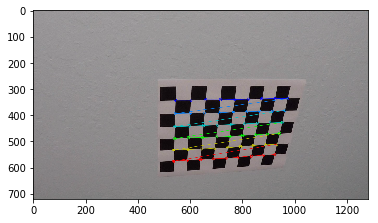

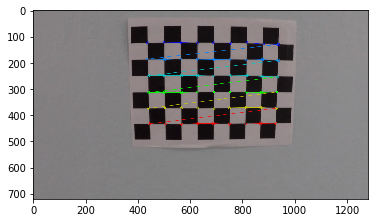

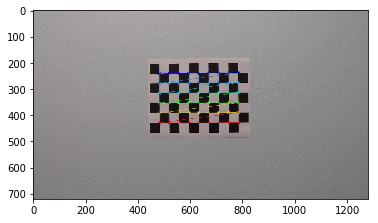

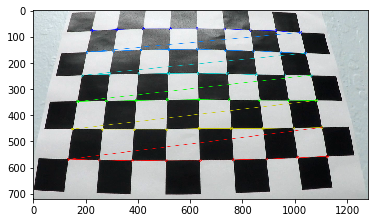

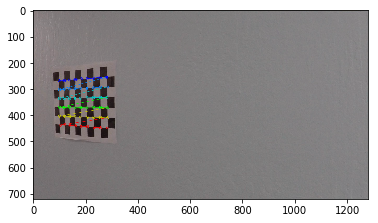

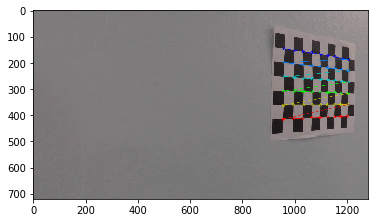

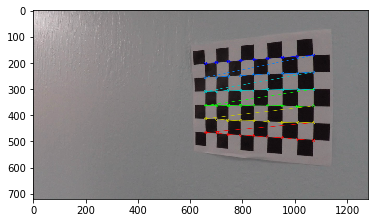

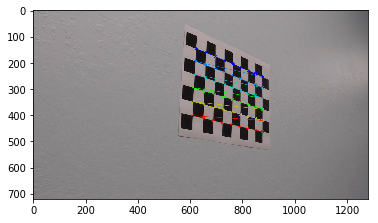

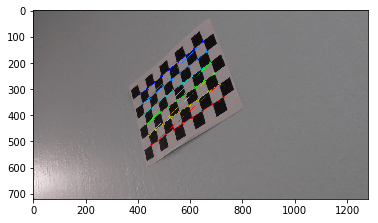

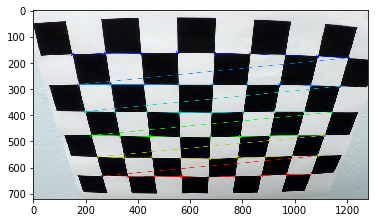

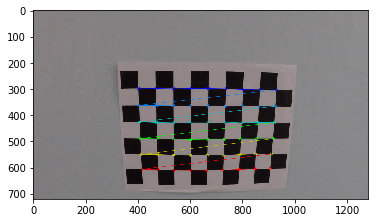

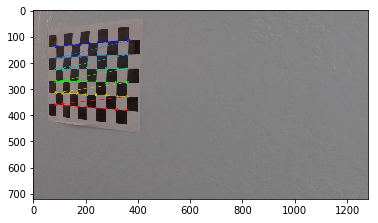

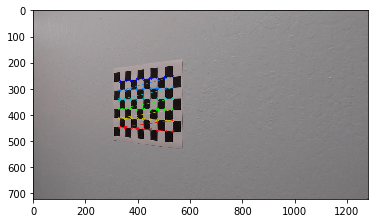

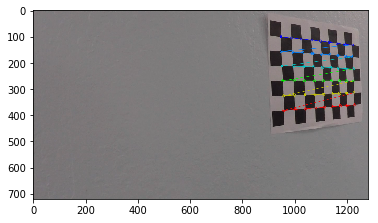

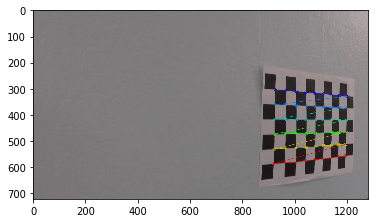

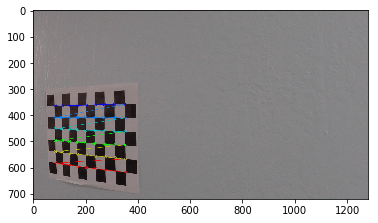

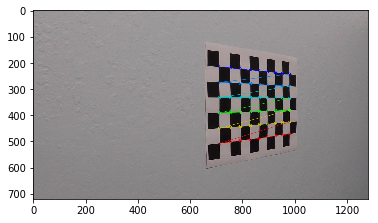

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.figure()
        plt.imshow(img)

cv2.destroyAllWindows()

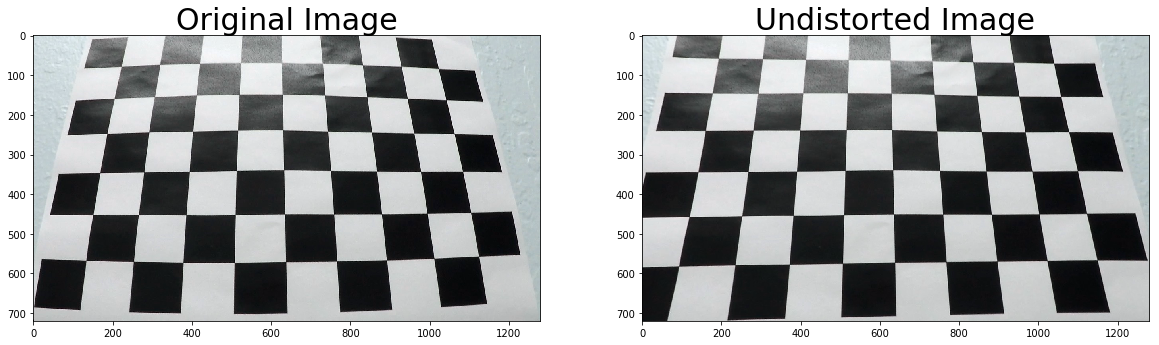

In [3]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration3.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( ".wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

#### Define function for apply distortion

In [4]:
def correctDistortion(img):
    ''' correct Distortion '''
    return cv2.undistort(img, mtx, dist, None, mtx)

## Pipeline (Test images)

------ 

### 1. Example for Apply the distortion correction

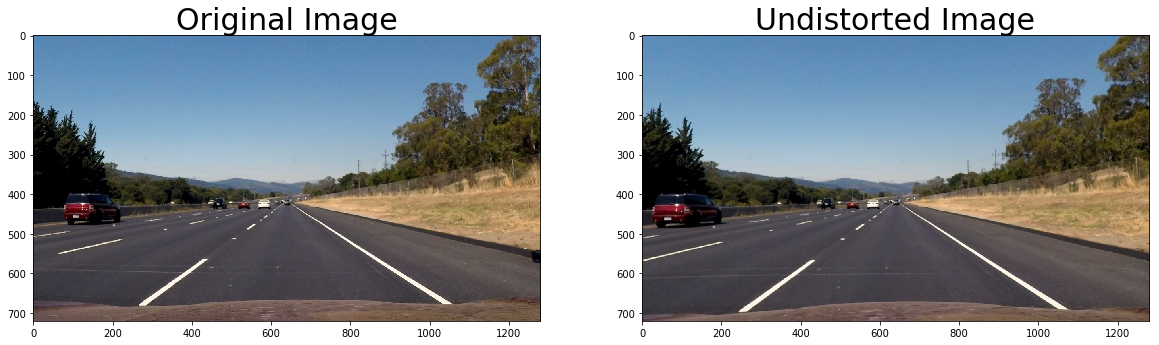

In [5]:
img = cv2.imread('./test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = correctDistortion(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

### 2. Has a binary image been created using color transforms, gradients or other methods?

### 2.1 color transofrmation and thresholds.


In [6]:
# https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/2b62a1c3-e151-4a0e-b6b6-e424fa46ceab/lessons/40ec78ee-fb7c-4b53-94a8-028c5c60b858/concepts/a1b70df9-638b-46bb-8af0-12c43dcfd0b4
def processImg(rbgImg, s_thresh=(200, 255), sx_thresh=(60, 100)):
#      s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(rbgImg)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    
    # Sobel x
    # Take the derivative in x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) 
    # Absolute x derivative to accentuate lines away from horizontal
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    return color_binary

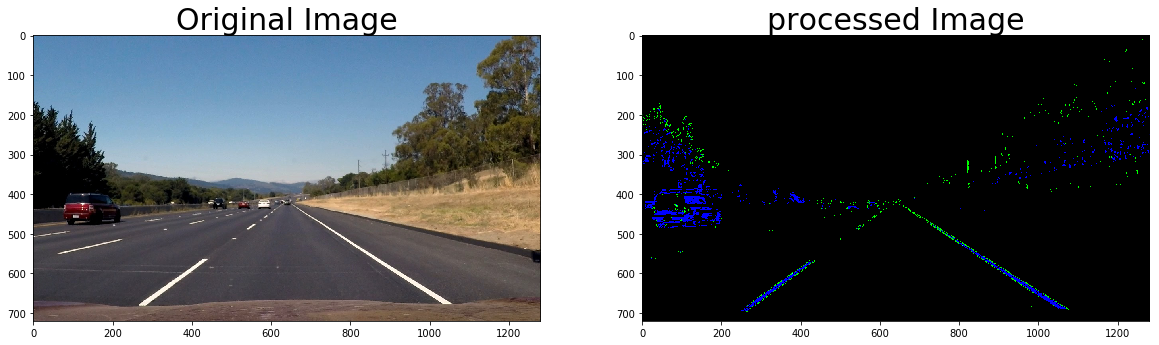

In [129]:
img = cv2.imread('./test_images/straight_lines2.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst = correctDistortion(img)
ori_img = np.copy(dst)
dst = processImg(dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('processed Image', fontsize=30)

### 2.2 Perspective transform


In [130]:
srcPt = np.float32([
    [585, 460],
    [203, 720],
    [1127, 720],
    [695, 460]
])

dstPt = np.float32([
    [320, 0],
    [320, 720],
    [960, 720],
    [960, 0]
])

M = cv2.getPerspectiveTransform(srcPt, dstPt)
Minv = cv2.getPerspectiveTransform(dstPt, srcPt)

def transformImgToBirdEyeView(img):
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

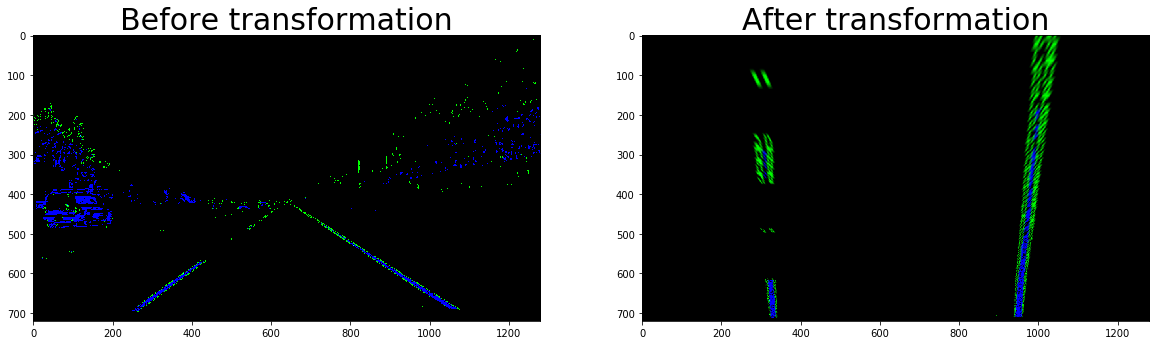

In [131]:
bridEyeDst_HSL = transformImgToBirdEyeView(dst)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(dst)
ax1.set_title('Before transformation', fontsize=30)
ax2.imshow(bridEyeDst_HSL)
ax2.set_title('After transformation', fontsize=30)

#### To gray scale

(720, 1280)


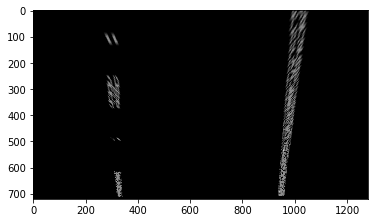

In [132]:
bridEyeDst = np.array(bridEyeDst_HSL[:,:,0] +bridEyeDst_HSL[:,:,1]+bridEyeDst_HSL[:,:,2]).reshape((bridEyeDst_HSL.shape[0],bridEyeDst_HSL.shape[1]))
grayDst = np.array(dst[:,:,0] +dst[:,:,1]+dst[:,:,2]).reshape((dst.shape[0],dst.shape[1]))
grayDst = np.dstack((grayDst,grayDst,grayDst))
print(bridEyeDst.shape)
plt.imshow(bridEyeDst, cmap=plt.get_cmap('gray'))

### 2.3 Line fitting


#### 2.3.1 find Line points

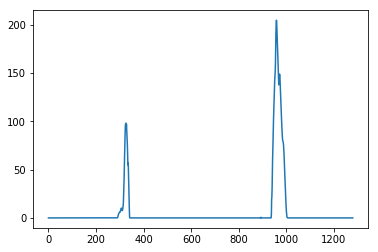

In [133]:
binary_warped = bridEyeDst
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)

(720, 1280)


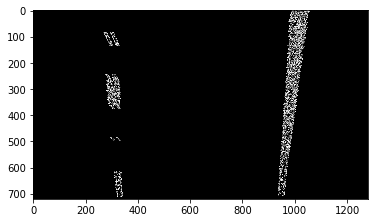

In [134]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
single_channel_gray = binary_warped*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(int(histogram.shape[0]/2))
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# print(histogram.shape)
# print(int(histogram.shape[0]/2))
# print(histogram[:midpoint].shape)
# print(np.argmax(histogram[:midpoint], axis=0))
# plt.plot(histogram[:midpoint])
# print(np.argmax(histogram[:midpoint]))
# print(leftx_base)
# print(rightx_base)
print(single_channel_gray.shape)
plt.imshow(out_img)

In [135]:
gray_img = out_img
out_img = np.copy(gray_img)
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

(720, 0)

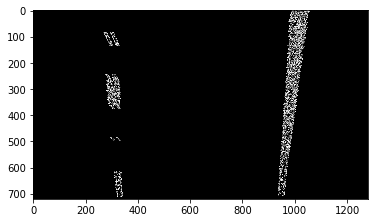

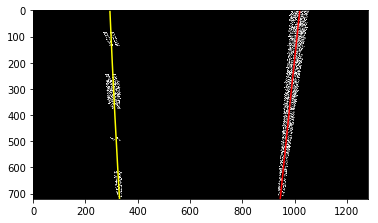

In [136]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

plt.figure()
plt.imshow(gray_img)
plt.figure()

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(gray_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='red')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [137]:

warp_zero = np.zeros_like(single_channel_gray).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
pts = np.array(np.hstack((pts_left, pts_right)), np.int32)



In [146]:
ori_img.dtype

dtype('uint8')

(1, 3, 2)


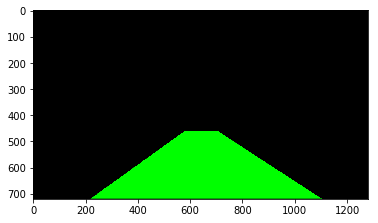

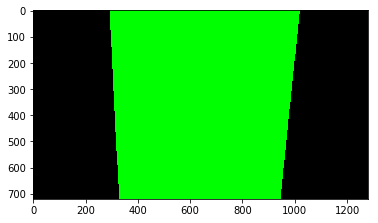

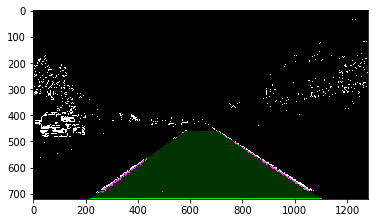

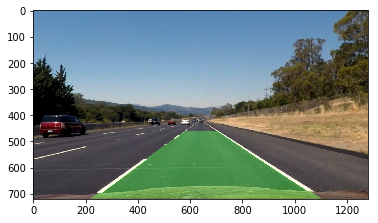

In [149]:

# cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
triangle = np.array([ [[10,30], [40,80], [10,90]] ], np.int32)
print(triangle.shape)
cv2.fillPoly(color_warp, pts, (0, 255, 0))

newwarp = cv2.warpPerspective(color_warp, Minv, (gray_img.shape[1], gray_img.shape[0])) 

res = cv2.addWeighted(np.array(grayDst,np.float32), 1, np.array(newwarp,np.float32), 0.3, 0.0)
rgb_weigthed = cv2.addWeighted(np.array(ori_img,np.uint8), 1, np.array(newwarp,np.uint8), 0.3, 0.0)

plt.imshow(newwarp)
plt.figure()
plt.imshow(color_warp)
plt.figure()
plt.imshow(res)
plt.figure()
plt.imshow(rgb_weigthed)